In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

# 1- Starter Code

In [2]:
words = open("../data/names.txt", "r").read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = 3
def build_dataset(words):  

  X, Y = [], []
  
  for w in words:

    context = [0] * block_size
    for ch in w + '.':

      ix = stoi[ch]

      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
for x, y in zip(Xtr[:15], Ytr[:15]):
  print("".join(itos[ix.item()] for ix in x), "---->", itos[y.item()])

... ----> y
..y ----> u
.yu ----> h
yuh ----> e
uhe ----> n
hen ----> g
eng ----> .
... ----> d
..d ----> i
.di ----> o
dio ----> n
ion ----> d
ond ----> r
ndr ----> e
dre ----> .


In [6]:
# Layers made in part 3
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out))
        self.weight /= fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim= True)
            # batch variance
            xvar = x.var(0, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [7]:
torch.manual_seed(42)

In [8]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias= False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = [C] + [p for l in layers for p in l.parameters()]
print(f"num parameters: {sum(p.numel() for p in parameters)}")

for p in parameters:
    p.requires_grad_()

num parameters: 12097


In [9]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters into vector space
    x = emb.view((emb.shape[0], -1)) # flatten
    for layer in layers:
        x = layer(x)
    # compute loss
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"step {i} loss {loss.item()}")

    lossi.append(loss.item())
    break

step 0 loss 3.2966105937957764


## 1.2 Fixing the Learning Rate Plot

In [14]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1, keepdim= True).data);

# 2- Pytorchifying our code
add `Embedding`, `Flatten` and `Sequential` Classes

## 2.1 Classes Definitions

In [11]:
# Layers made in part 3
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out))
        self.weight /= fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim= True)
            # batch variance
            xvar = x.var(0, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    
# ---------------- new ----------------
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view((x.shape[0], -1))
        return self.out
    
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        self.out = x
        return self.out

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

## 2.2 Initialize the model

In [12]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),

    Linear(n_embd * block_size, n_hidden, bias= False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(f"num parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_()


num parameters: 12097


## 2.3 Training the model

In [13]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass is now simpler
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"step {i} loss {loss.item()}")

    lossi.append(loss.item())

    break


step 0 loss 3.631577253341675


## 2.4 Model Evaluation

In [14]:
for layer in model.layers:
    layer.training = False

In [15]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "valid": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    return loss.item()

print("train", split_loss("train"))
print("valid", split_loss("valid"))

train 3.451620578765869
valid 3.4509992599487305


## 2.5- Sample from the model

In [16]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim = 1)

        ix = torch.multinomial(probs, num_samples = 1).item()

        # Shift the Context Window
        context = context[1:] + [ix]

        if ix == 0:
            break

        out.append(ix)
    
    print("".join(itos[i] for i in out))
        

oezwcqorwedcve
xmin
ejtzsgxiycvzkoycihmo
zuzjwfhcspltyxcnrzifjkdaiymwjgbzcg
cudt
ssvlpzyuxedxxjpvdzjtrvwgwdcdjduoexe
owp
rnwnj
fl
qfouarko
e
mvomiknkdqfxlzya
erlllyoohutgyisdomggurjbzbanruvtccvdwij
slssfsqazlhwnkvggwkouuqxvwdgnosyjcgatowdsvqzwdfvwapsusxpkzkszqvlzcwdtitdfmiobkblwfrpsbvigvqawilrngbyqbddjexivtsifoucphhp
zbrzqf
pajwmybc
cvxajrjbqgkwsjhvpcrdojhqcgl
cfenecniyafpejhgzkqhltpchnsnyxqjewigdqiwdyouzxn
fjehbkvopkjtneueuuaid
uyxxovejhylbczebrpjviigagewuuhvjepahdajzlduxfyexjrlrpfbpiazcnersmabjaecoegmisoxobkpxopoddtbn


# 3- Building the WaveNet Model

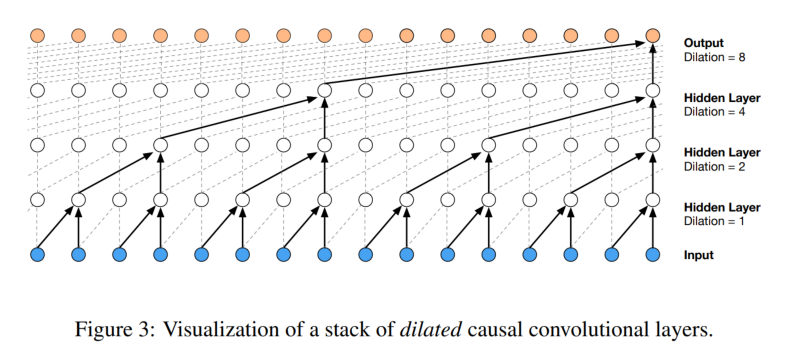

In [9]:
# preview an image
import matplotlib.pyplot as plt
plt.figure(figsize=(10,20))
plt.imshow(plt.imread("../images/dilated_casual_conv.png"))
plt.axis("off");

## 3.1 Changing Dataset blocksize

In [17]:
block_size = 8
def build_dataset(words):  

  X, Y = [], []
  
  for w in words:

    context = [0] * block_size
    for ch in w + '.':

      ix = stoi[ch]

      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [18]:
for x, y in zip(Xtr[:15], Ytr[:15]):
  print("".join(itos[ix.item()] for ix in x), "---->", itos[y.item()])

........ ----> e
.......e ----> b
......eb ----> r
.....ebr ----> i
....ebri ----> m
...ebrim ----> a
..ebrima ----> .
........ ----> h
.......h ----> i
......hi ----> l
.....hil ----> t
....hilt ----> o
...hilto ----> n
..hilton ----> .
........ ----> j


## 3.2 Initializing a normal network

In [19]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),

    Linear(n_embd * block_size, n_hidden, bias= False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(f"num parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_()


num parameters: 22097


## 3.3 Implementing WaveNet

### 3.3.1 Shape Exploration

In [20]:
# look at batch of 5 examples (it's 4 in the original video but I changed it to 5 to prevent confusion)
ix = torch.randint(0, Xtr.shape[0], (5,))
Xb, Yb = Xtr[ix], Ytr[ix]

logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([5, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 20],
        [ 0,  0,  0,  0,  0,  0,  0,  8],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0, 18,  1, 17, 21],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [21]:
for layer in model.layers:
    print(f"{layer.__class__.__name__} has output size of: {layer.out.shape}")

Embedding has output size of: torch.Size([5, 8, 10])
Flatten has output size of: torch.Size([5, 80])
Linear has output size of: torch.Size([5, 200])
BatchNorm1d has output size of: torch.Size([5, 200])
Tanh has output size of: torch.Size([5, 200])
Linear has output size of: torch.Size([5, 27])


we don't want to process the 8 characters at the same time
```
1 2 3 4 5 6 7 8
```
but we want to process them in 4 groups of 2 characters in parallel
```
(1 2) (3 4) (5 6) (7 8)
```

so instead of multiplying `(5, 80) @ (80, 200) = (5, 200)` we want to multiply `(5, 4, 20) @ (20, 200) = (5, 4, 200)`

In [22]:
# output of layer 0
e = torch.randn(5, 8, 10)
# contacenate even and odd (on character dimension) elements of the last dimension
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim = 2)
# you can do the same using view
implicit = e.view(5, 4, 20)

(implicit == explicit).all()

tensor(True)

### 3.3.2 - FlattenConsectutive Class

In [23]:
# Reimplement Flatten
class FlattenConsecutive:
    def __init__(self, n):
        # n is the number of consecutive elements we want (2 in our example)
        self.n = n
    
    def __call__(self, x):
        # in our example: B = 5, T = 8, C = 10
        B, T, C = x.shape
        # we want to convert X to (5, 4, 20)
        x = x.view(B, T // self.n, C * self.n)

        if x.shape[1] == 1:
            x = x.squeeze(1)
        
        self.out = x
        return self.out

    def parameters(self):
        return []

### 3.3.3 - previous behavior using FlattenConsecutive

In [24]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    # calling FlattenConsecutive(block_size) will return in the same previous behavior
    FlattenConsecutive(block_size),

    Linear(n_embd * block_size, n_hidden, bias= False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(f"num parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_()


num parameters: 22097


In [25]:
ix = torch.randint(0, Xtr.shape[0], (5,))
Xb, Yb = Xtr[ix], Ytr[ix]

logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([5, 8])


tensor([[ 0,  0,  0, 13, 15,  8,  1, 13],
        [ 0,  0,  0,  0, 11,  1, 19,  9],
        [ 0,  0,  0,  0,  0, 10,  1, 25],
        [ 0,  0,  0,  0,  0, 18,  9,  8],
        [ 0,  0,  0,  0,  0,  0,  0,  4]])

In [26]:
for layer in model.layers:
    print(f"{layer.__class__.__name__} has output size of: {(layer.out.shape)}")

Embedding has output size of: torch.Size([5, 8, 10])
FlattenConsecutive has output size of: torch.Size([5, 80])
Linear has output size of: torch.Size([5, 200])
BatchNorm1d has output size of: torch.Size([5, 200])
Tanh has output size of: torch.Size([5, 200])
Linear has output size of: torch.Size([5, 27])


### 3.3.4 - Processing Hierarchically: FlattenConsecutive(2)

In [27]:
n_embd = 10
# changing the number of hidden units to 68 keeps the same number of parameters as the previous model (22k)
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias= False), BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias= False), BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias= False), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(f"num parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_()

num parameters: 22397


In [28]:
ix = torch.randint(0, Xtr.shape[0], (5,))
Xb, Yb = Xtr[ix], Ytr[ix]

logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([5, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 16],
        [ 0,  0,  0,  0,  0, 20,  5, 25],
        [ 0,  0,  0,  0,  0,  0,  2, 18],
        [ 0,  0,  0,  6,  1, 18,  8,  1],
        [ 0,  0,  0,  0,  0,  0, 19,  8]])

In [29]:
for layer in model.layers:
    print(f"{layer.__class__.__name__} has output size of: {layer.out.shape}")

Embedding has output size of: torch.Size([5, 8, 10])
FlattenConsecutive has output size of: torch.Size([5, 4, 20])
Linear has output size of: torch.Size([5, 4, 68])
BatchNorm1d has output size of: torch.Size([5, 4, 68])
Tanh has output size of: torch.Size([5, 4, 68])
FlattenConsecutive has output size of: torch.Size([5, 2, 136])
Linear has output size of: torch.Size([5, 2, 68])
BatchNorm1d has output size of: torch.Size([5, 2, 68])
Tanh has output size of: torch.Size([5, 2, 68])
FlattenConsecutive has output size of: torch.Size([5, 136])
Linear has output size of: torch.Size([5, 68])
BatchNorm1d has output size of: torch.Size([5, 68])
Tanh has output size of: torch.Size([5, 68])
Linear has output size of: torch.Size([5, 27])


however, this network gives the same loss = 2.0

### 3.3.5 - Fixing BatchNorm Bug
we implemented batchnorm for X 2D only

we calculated mean and variance for the first dimension only

we don't want to average over the batch dimension only, but also over the 2nd dimension (the 4 groups of 2 characters)

In [30]:
e = torch.rand(32, 4, 68)
emean = e.mean(dim = (0,1), keepdim = True) # (1, 1, 68)
evar = e.var((0,1), keepdim = True) # (1, 1, 68)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)

print(ehat.shape)
print(f"shape of running mean is {model.layers[3].running_mean.shape}")

torch.Size([32, 4, 68])
shape of running mean is torch.Size([1, 4, 68])


In [31]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # determine the dimension to reduce over
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            
            xmean = x.mean(dim, keepdim= True)
            # batch variance
            xvar = x.var(dim, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [32]:
n_embd = 10
# changing the number of hidden units to 68 keeps the same number of parameters as the previous model (22k)
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias= False), BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias= False), BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias= False), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(f"num parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_()

num parameters: 22397


The model improves a little bit (2.029 -> 2.022)

# 4- Final Implementation

In [85]:
# Layers made in part 3
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out))
        self.weight /= fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # determine the dimension to reduce over
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            
            xmean = x.mean(dim, keepdim= True)
            # batch variance
            xvar = x.var(dim, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view((x.shape[0], -1))
        return self.out
    
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        self.out = x
        return self.out

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

class FlattenConsecutive:
    def __init__(self, n):
        # n is the number of consecutive elements we want (2 in our example)
        self.n = n
    
    def __call__(self, x):
        # in our example: B = 5, T = 8, C = 10
        B, T, C = x.shape
        # we want to convert X to (5, 4, 20)
        x = x.view(B, T // self.n, C * self.n)

        if x.shape[1] == 1:
            x = x.squeeze(1)
        
        self.out = x
        return self.out

    def parameters(self):
        return []

In [86]:
n_embd = 24 
n_hidden = 128 

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [69]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 2.1721
  10000/ 200000: 1.8982
  20000/ 200000: 2.0865
  30000/ 200000: 1.7060
  40000/ 200000: 1.5556
  50000/ 200000: 1.8686
  60000/ 200000: 1.6639
  70000/ 200000: 1.8981
  80000/ 200000: 1.8715
  90000/ 200000: 1.8957
 100000/ 200000: 2.0003
 110000/ 200000: 1.7974
 120000/ 200000: 1.6178
 130000/ 200000: 1.9566
 140000/ 200000: 1.6385
 150000/ 200000: 1.7304
 160000/ 200000: 1.9413
 170000/ 200000: 1.8178
 180000/ 200000: 1.7655
 190000/ 200000: 1.3521


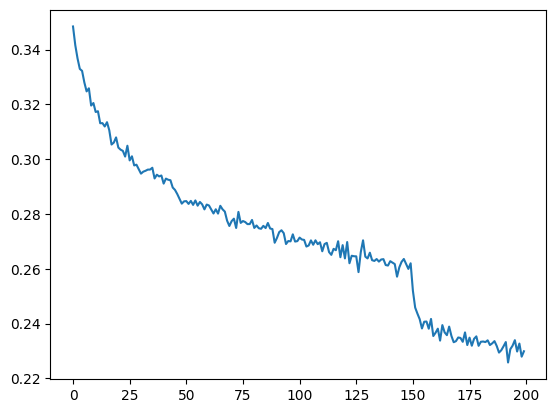

In [75]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1, keepdim= True).data);

In [70]:
for layer in model.layers:
    layer.training = False

In [73]:
print("train", split_loss("train"))
print("valid", split_loss("valid"))

train 1.716454267501831
valid 2.0466954708099365


In [74]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Forward pass
        logits = model(torch.tensor([context]).reshape(1, -1))
        probs = F.softmax(logits, dim = 1)

        ix = torch.multinomial(probs, num_samples = 1).item()

        # Shift the Context Window
        context = context[1:] + [ix]

        if ix == 0:
            break

        out.append(ix)
    
    print("".join(itos[i] for i in out))

meliha
staphoor
alepa
damarius
chloe
kaven
darahet
iosir
noah
pabriani
kaylan
akhilynn
adae
ori
rowen
bodey
bekar
fawliamal
laymarie
holsy


validation loss becomes 1.993